In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import zscore

from pathlib import Path
from typing import Dict, Tuple

# Load the data

df = pd.read_csv('../data/benin-malanville.csv')

print(df.head())
# Display summary statistics for numeric columns

summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)


**Data Cleaning**


In [ ]:
def data_clean(data):
    # Replace specific invalid numeric values and infinite values with NaN
    data = data.replace([-1, np.inf, -np.inf], np.nan)

    # Convert invalid or corrupt timestamps to NaN
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

    # Fill missing values in numeric columns with the respective column's mean
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].apply(lambda x: x.fillna(x.mean()))

    # Eliminate any duplicate rows from the dataset
    data.drop_duplicates(inplace=True)

    return data

**Data Analysis**


In [ ]:
def process_and_analyze(data, location_name, variables=None):
    """
    Processes and performs analysis on solar radiation data for a given location.

    Args:
        data (pandas.DataFrame): The dataset containing solar radiation measurements.
        location_name (str): The name of the location to be analyzed.
        variables (list, optional): A list of specific variable names for analysis.
            If not provided, all numeric columns are analyzed. Defaults to None.

    Returns:
        None
    """

    # Clean the dataset and handle missing values
    data = data_clean(data)

    if data.empty:
        print(f"No data available after cleaning for {location_name}.")
        return

    # Set the 'Timestamp' column as the index for time-series operations
    data.set_index('Timestamp', inplace=True)

    # Generate summary statistics for numerical columns
    summary_stats = data.describe(include=[np.number])
    print(f"\nSummary statistics for {location_name}:")
    print(summary_stats)

    # Analyze time-series patterns and trends
    if not variables:
        variables = ['GHI', 'DNI', 'DHI', 'Tamb']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data[variables])
    plt.title(f"Time-series trends for {location_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

    # Perform correlation analysis between variables
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation Matrix for {location_name}")
    plt.show()

    # Create scatter plots to visualize relationships and detect anomalies
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data, x='Tamb', y='GHI', hue='Precipitation', palette='viridis', s=20)
    plt.title(f"Scatter Plot of Tamb vs. GHI with Precipitation for {location_name}")
    plt.xlabel("Tamb (°C)")
    plt.ylabel("GHI (W/m²)")
    plt.show()

    # Use box plots to identify outliers and distribution spread
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data[variables])
    plt.title(f"Box Plot for {location_name}")
    plt.show()

    # Plot a histogram to examine the distribution of GHI
    plt.figure(figsize=(12, 6))
    sns.histplot(data['GHI'], kde=True)
    plt.title(f"Histogram of GHI for {location_name}")
    plt.xlabel("GHI (W/m²)")
    plt.ylabel("Count")
    plt.show()

    # Report on any missing values after the cleaning and imputation process
    missing_values = data.isnull().sum()
    print(f"\nMissing values after cleaning and imputing for {location_name}:")
    print(missing_values)

  #1. Missing Values Check
    missing_values = df.isna().sum()
    print("Missing Values per Column:")
    print(missing_values)
    df.drop(columns=['Comments'], inplace=True)

    print('2. Handling Negative Irradiance Values')
    irradiance_cols = ['GHI', 'DNI', 'DHI']
    df[irradiance_cols] = df[irradiance_cols].clip(lower=0)

    print('3.Outlier Detection (Z-Score Method)')

    from scipy import stats
    numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    z_scores = stats.zscore(df[numeric_cols])
    outliers = (np.abs(z_scores) > 3).any(axis=1)
    print(f"Found {outliers.sum()} outliers (|Z| > 3)")
    for col in numeric_cols:
        df.loc[outliers, col] = df[col].median()

In [ ]:
# Load data from CSV files
try:
    benin_data = pd.read_csv("../data/benin-malanville.csv")
    sierra_leone_data = pd.read_csv("../data/sierraleone-bumbuna.csv")
    togo_data = pd.read_csv("../data/togo-dapaong_qc.csv")
except FileNotFoundError:
    print("Error: One or more CSV files not found.")
    exit()

**Apply the data analysis on each dataset**


In [ ]:
def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """Generate comprehensive data quality report"""
    report = pd.DataFrame({
        'Missing Values': df.isna().sum(),
        'Zero Values': (df == 0).sum(),
        'Negative Values': (df.select_dtypes(include=np.number) < 0).sum()
    })

    # Value range checks
    ranges = {
        'GHI': (0, 1500),
        'RH': (0, 100),
        'Tamb': (-20, 60)
    }
    for col, (min_val, max_val) in ranges.items():
        report.loc[col, 'Out of Range'] = ((df[col] < min_val) | (df[col] > max_val)).sum()

    return report

quality_report = data_quality_report(full_df)
display(quality_report.style.background_gradient(cmap='Reds'))

In [ ]:
def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """Generate comprehensive data quality report"""
    report = pd.DataFrame({
        'Missing Values': df.isna().sum(),
        'Zero Values': (df == 0).sum(),
        'Negative Values': (df.select_dtypes(include=np.number) < 0).sum()
    })

    # Value range checks
    ranges = {
        'GHI': (0, 1500),
        'RH': (0, 100),
        'Tamb': (-20, 60)
    }
    for col, (min_val, max_val) in ranges.items():
        report.loc[col, 'Out of Range'] = ((df[col] < min_val) | (df[col] > max_val)).sum()

    return report

quality_report = data_quality_report(full_df)
display(quality_report.style.background_gradient(cmap='Reds'))


Summary statistics for Benin - Malanville:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      243.406679     169.419243     116.829589     236.589496   
std       330.091170     260.992408     158.150991     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.400000      -2.100000       0.000000   
50%         7.700000      -0.100000       7.800000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0

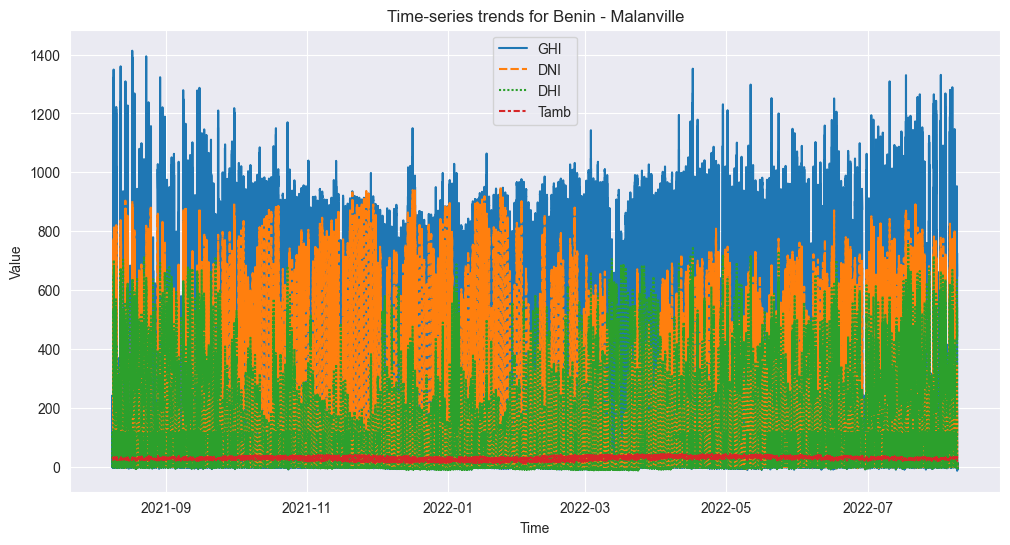

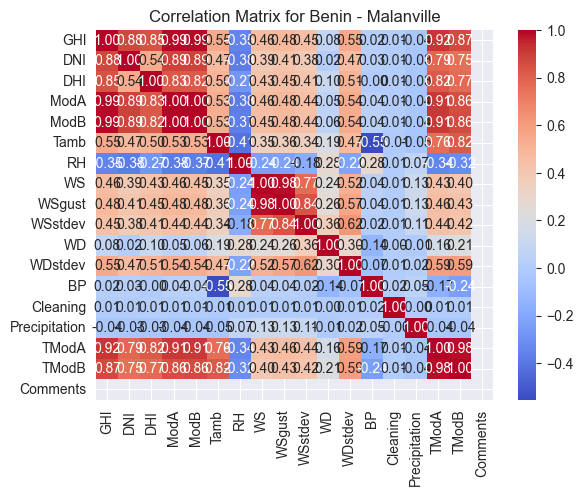

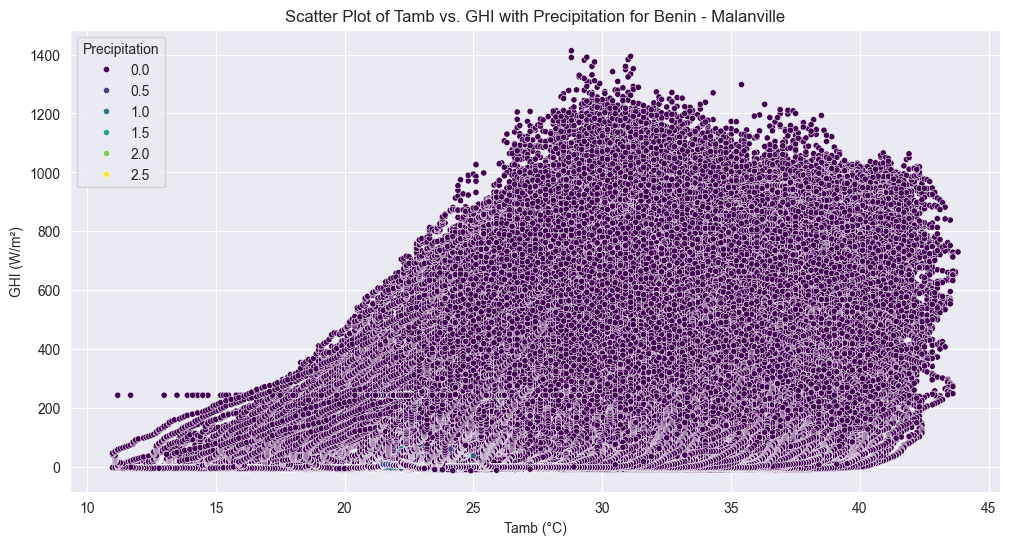

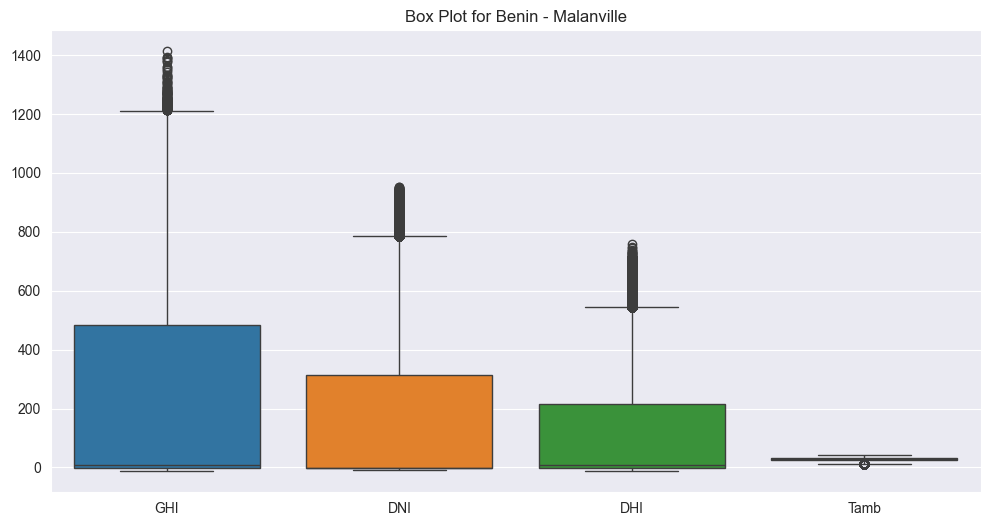

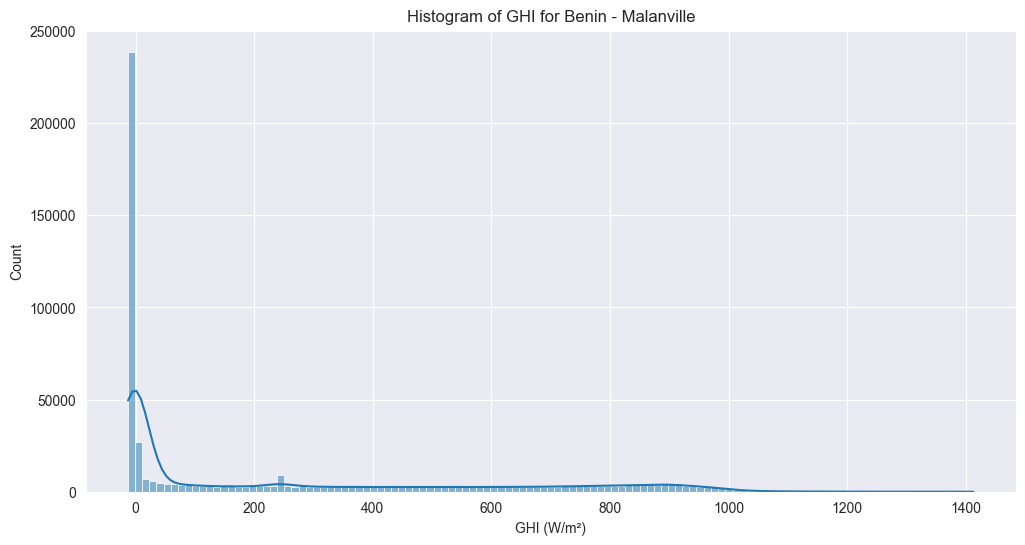


Missing values after cleaning and imputing for Benin - Malanville:
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [49]:
process_and_analyze(benin_data, "Benin - Malanville")


In [ ]:
process_and_analyze(sierra_leone_data, "Sierra Leone - Bunbuna")


In [ ]:
process_and_analyze(togo_data, "Togo - Dapaong qc")


4. Data Cleaning and Quality Assessment


In [ ]:
#ata Cleaning and Quality Assessment

def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """Generate comprehensive data quality report"""
    report = pd.DataFrame({
        'Missing Values': df.isna().sum(),
        'Zero Values': (df == 0).sum(),
        'Negative Values': (df.select_dtypes(include=np.number) < 0).sum()
    })

    # Value range checks
    ranges = {
        'GHI': (0, 1500),
        'RH': (0, 100),
        'Tamb': (-20, 60)
    }
    for col, (min_val, max_val) in ranges.items():
        report.loc[col, 'Out of Range'] = ((df[col] < min_val) | (df[col] > max_val)).sum()

    return report

quality_report = data_quality_report(full_df)
display(quality_report.style.background_gradient(cmap='Reds'))

In [47]:
irradiance_cols = ['GHI', 'DNI', 'DHI']
df[irradiance_cols] = df[irradiance_cols].clip(lower=0)

3. Outlier Detection (Z-Score Method)


In [46]:
from scipy import stats
numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = stats.zscore(df[numeric_cols])
outliers = (np.abs(z_scores) > 3).any(axis=1)
print(f"Found {outliers.sum()} outliers (|Z| > 3)")
for col in numeric_cols:
    df.loc[outliers, col] = df[col].median()

Found 3776 outliers (|Z| > 3)


4. Wind Speed Data Validation


In [45]:
# Check for WSgust < WS (physically unlikely)
invalid_wind = df['WSgust'] < df['WS']
print(f"Found {invalid_wind.sum()} rows where WSgust < WS")

# Fix: Set WSgust = WS where invalid
df.loc[invalid_wind, 'WSgust'] = df.loc[invalid_wind, 'WS']

Found 0 rows where WSgust < WS


5. Export Cleaned Data


In [ ]:
import os
os.makedirs('data', exist_ok=True)
df.to_csv('benin_clean.csv', index=False)  # Saves in current working directory
print("Cleaned data saved to data/benin_clean.csv")

Time Series Analysis

In [24]:
# Convert 'Timestamp' to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Filter for daytime (GHI > 0) to focus on solar activity
daytime_df = df[df['GHI'] > 0]

2. Line Charts: GHI, DNI, DHI, and Tamb Over Time


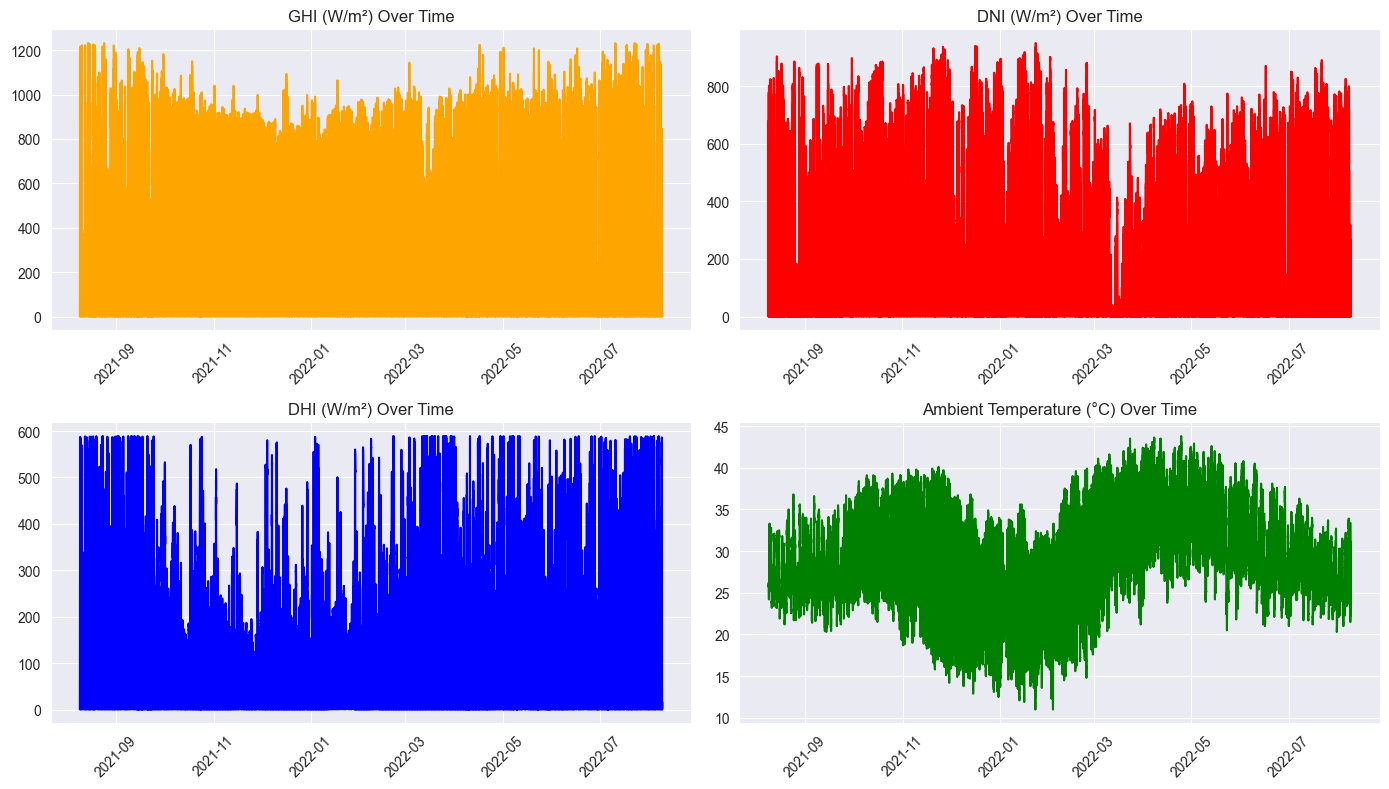

In [25]:
plt.figure(figsize=(14, 8))

# Plot GHI (Global Horizontal Irradiance)
plt.subplot(2, 2, 1)
plt.plot(daytime_df.index, daytime_df['GHI'], color='orange', label='GHI')
plt.title('GHI (W/m²) Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Plot DNI (Direct Normal Irradiance)
plt.subplot(2, 2, 2)
plt.plot(daytime_df.index, daytime_df['DNI'], color='red', label='DNI')
plt.title('DNI (W/m²) Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Plot DHI (Diffuse Horizontal Irradiance)
plt.subplot(2, 2, 3)
plt.plot(daytime_df.index, daytime_df['DHI'], color='blue', label='DHI')
plt.title('DHI (W/m²) Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Plot Tamb (Ambient Temperature)
plt.subplot(2, 2, 4)
plt.plot(df.index, df['Tamb'], color='green', label='Tamb')
plt.title('Ambient Temperature (°C) Over Time')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

3. Bar Charts: Aggregated Trends


<Figure size 1200x600 with 0 Axes>

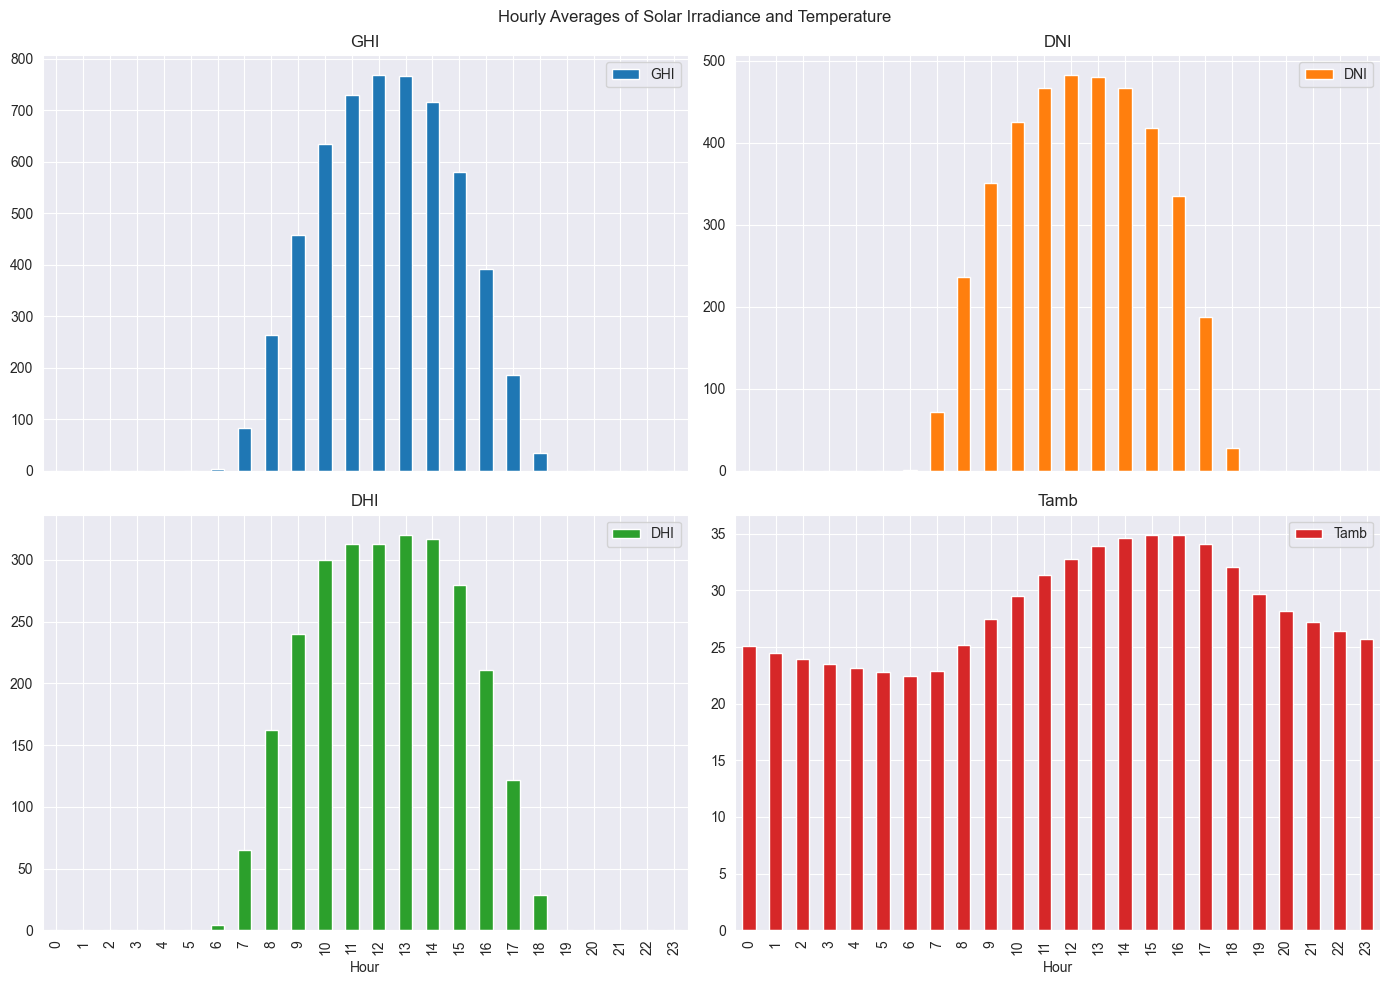

In [26]:
# Extract hour from Timestamp
df['Hour'] = df.index.hour

# Group by hour and compute mean
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Plot
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(14, 10))
plt.suptitle('Hourly Averages of Solar Irradiance and Temperature')
plt.tight_layout()
plt.show()

4. Anomaly Detection

Unusual Spikes in Irradiance


In [27]:
# Identify sudden GHI spikes (e.g., sensor errors)
ghi_std = df['GHI'].std()
anomalies = df[df['GHI'] > (df['GHI'].mean() + 3 * ghi_std)]
print(f"Found {len(anomalies)} GHI anomalies (3σ threshold):")
print(anomalies[['GHI', 'DNI', 'DHI']].head())

Found 43 GHI anomalies (3σ threshold):
                        GHI    DNI    DHI
Timestamp                                
2021-08-09 14:12:00  1214.0  710.4  522.6
2021-08-09 14:29:00  1216.0  791.9  468.3
2021-08-10 12:35:00  1215.0  805.0  393.6
2021-08-10 12:37:00  1212.0  789.0  404.2
2021-08-10 13:46:00  1220.0  711.9  504.0


Temperature vs. Irradiance Mismatch


In [28]:
# Check if high GHI but low Tamb (unusual)
suspicious = df[(df['GHI'] > 800) & (df['Tamb'] < 25)]
print(f"Found {len(suspicious)} cases of high GHI but low Tamb:")
print(suspicious[['GHI', 'Tamb']])

Found 118 cases of high GHI but low Tamb:
                       GHI  Tamb
Timestamp                       
2021-09-10 11:29:00  881.0  24.2
2021-09-10 11:30:00  913.0  24.3
2021-09-10 11:31:00  920.0  24.4
2021-09-10 11:32:00  939.0  24.4
2021-09-10 11:33:00  955.0  24.4
...                    ...   ...
2022-02-04 11:29:00  801.0  24.9
2022-02-04 11:32:00  807.0  24.9
2022-02-04 11:33:00  808.0  24.9
2022-02-04 11:36:00  820.0  24.9
2022-02-04 11:48:00  837.0  24.9

[118 rows x 2 columns]


Cleaning Impact

Comparing Module Temperatures (ModA & ModB) Before vs. After Cleaning


Mark Cleaning Flags

In [29]:
# --- Detect outliers (Z-score > 3) ---
numeric_cols = ['ModA', 'ModB']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outliers = (z_scores > 3).any(axis=1)

# Add a 'Cleaning_Flag' column
df['Cleaning_Flag'] = np.where(outliers, 'Modified', 'Original')

Step 2: Plot Pre-Clean vs. Post-Clean Averages

Compare the mean ModA and ModB for original vs. modified rows.




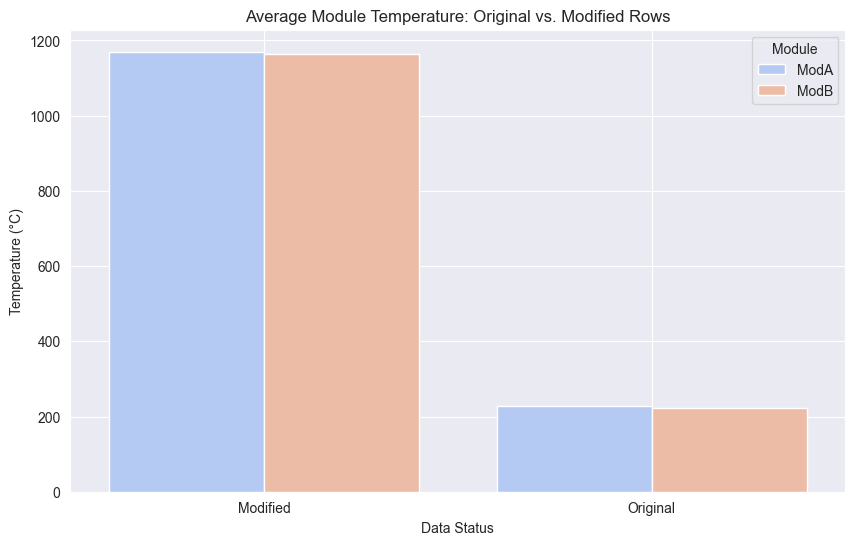

In [30]:
# Group by cleaning flag and compute mean
grouped = df.groupby('Cleaning_Flag')[['ModA', 'ModB']].mean().reset_index()

# Melt for Seaborn plotting
melted = pd.melt(grouped, id_vars='Cleaning_Flag', var_name='Module', value_name='Temperature')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Cleaning_Flag', y='Temperature', hue='Module', palette='coolwarm')
plt.title('Average Module Temperature: Original vs. Modified Rows')
plt.ylabel('Temperature (°C)')
plt.xlabel('Data Status')
plt.grid(True)
plt.show()

Step 3: Boxplot for Distribution Comparison

Visualize the spread of temperatures before and after cleaning.



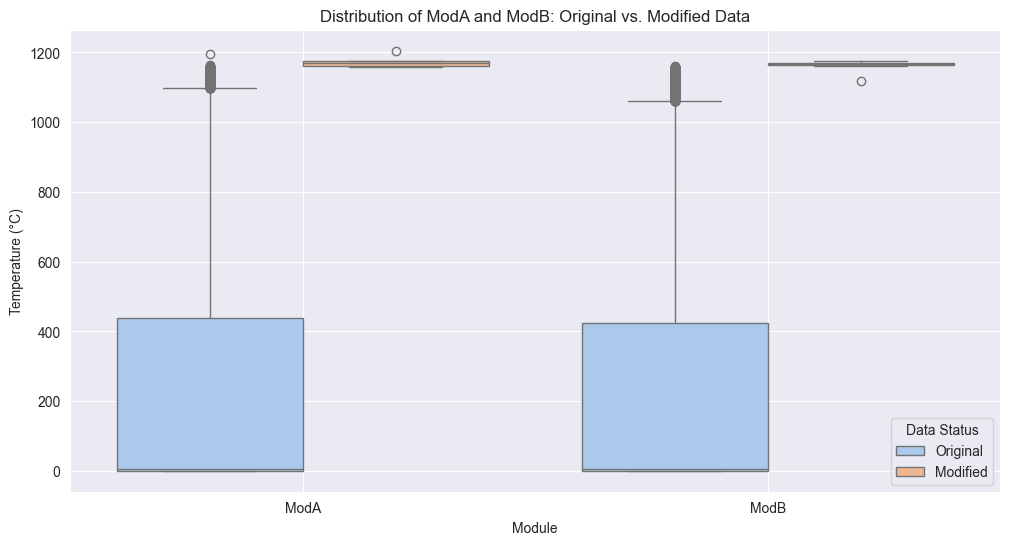

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pd.melt(df, id_vars='Cleaning_Flag', value_vars=['ModA', 'ModB']),
    x='variable',
    y='value',
    hue='Cleaning_Flag',
    palette='pastel'
)
plt.title('Distribution of ModA and ModB: Original vs. Modified Data')
plt.xlabel('Module')
plt.ylabel('Temperature (°C)')
plt.legend(title='Data Status')
plt.grid(True)
plt.show()

Step 4: Summary Table


In [32]:
summary = df.groupby('Cleaning_Flag').agg({
    'ModA': ['mean', 'std', 'count'],
    'ModB': ['mean', 'std', 'count']
})
print(summary)

                      ModA                             ModB              \
                      mean         std   count         mean         std   
Cleaning_Flag                                                             
Modified       1169.964286   11.973664      14  1164.050000   14.090955   
Original        228.796513  322.890615  525586   221.544734  312.992275   

                       
                count  
Cleaning_Flag          
Modified           14  
Original       525586  


Correlation & Relationship Analysis
1. Heatmap of Correlations

Visualize relationships between solar irradiance (GHI, DNI, DHI) and module temperatures (TModA, TModB).




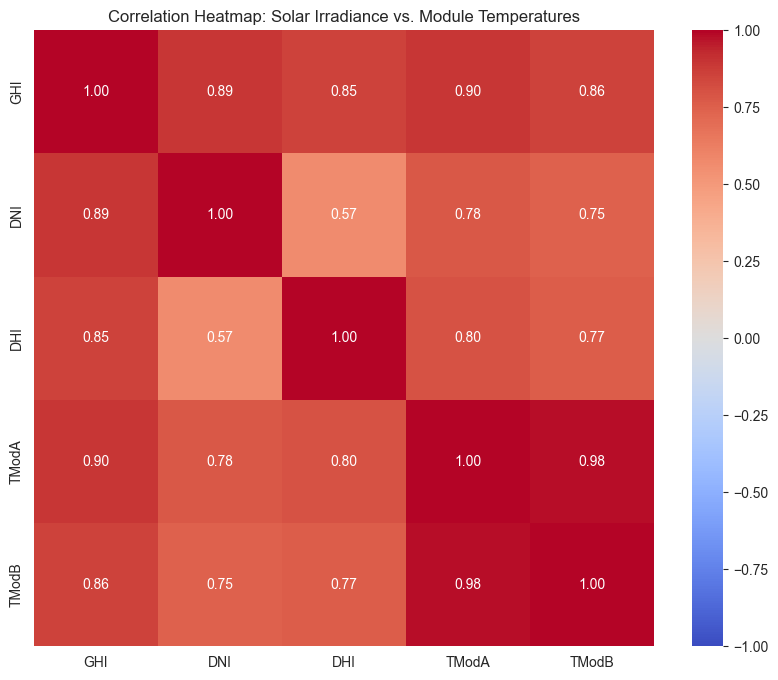

In [33]:
# Select key columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap: Solar Irradiance vs. Module Temperatures')
plt.show()

Wind & Distribution Analysis
1. Wind Speed (WS) & Gust (WSgust) Analysis

A. Distribution Plots


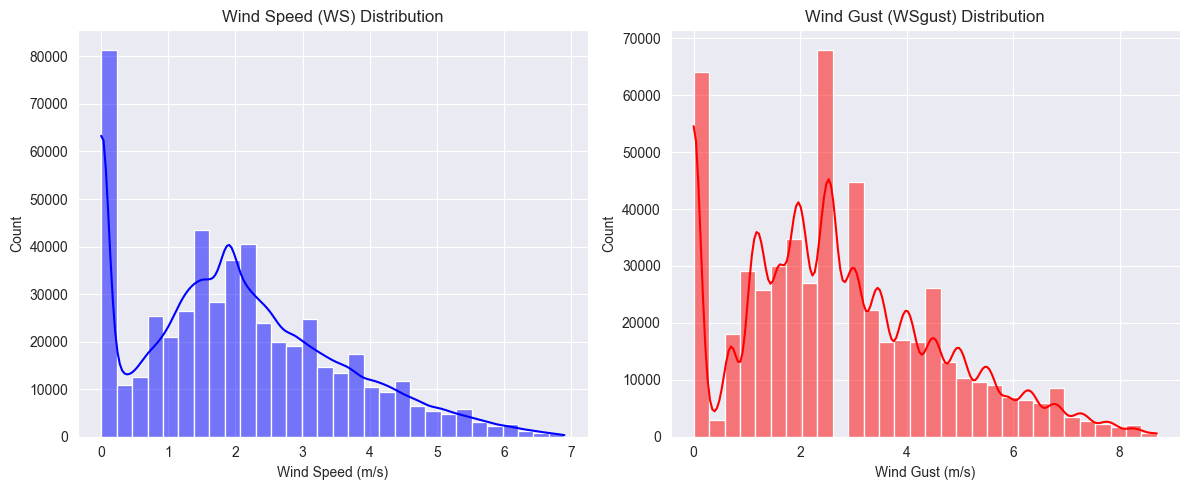

In [35]:
plt.figure(figsize=(12, 5))

# Wind Speed (WS)
plt.subplot(1, 2, 1)
sns.histplot(df['WS'], bins=30, kde=True, color='blue')
plt.title('Wind Speed (WS) Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.grid(True)

# Wind Gust (WSgust)
plt.subplot(1, 2, 2)
sns.histplot(df['WSgust'], bins=30, kde=True, color='red')
plt.title('Wind Gust (WSgust) Distribution')
plt.xlabel('Wind Gust (m/s)')
plt.grid(True)

plt.tight_layout()
plt.show()

B. Boxplot Comparison


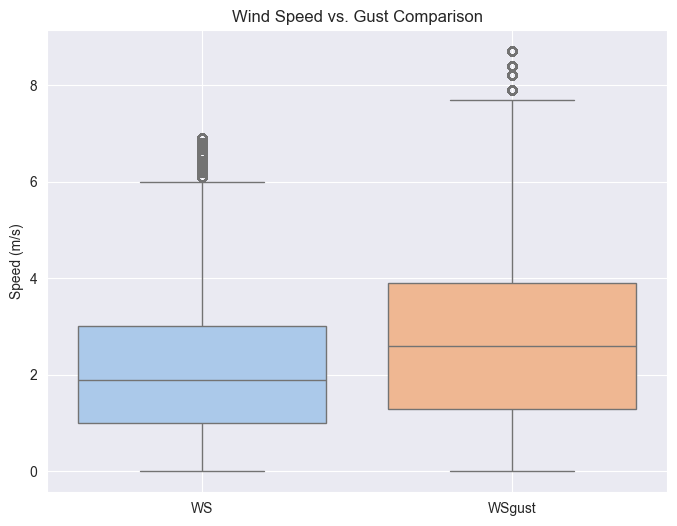

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['WS', 'WSgust']], palette='pastel')
plt.title('Wind Speed vs. Gust Comparison')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.show()

2. Wind Direction (WD) Analysis

A. Circular Histogram (Polar Plot)


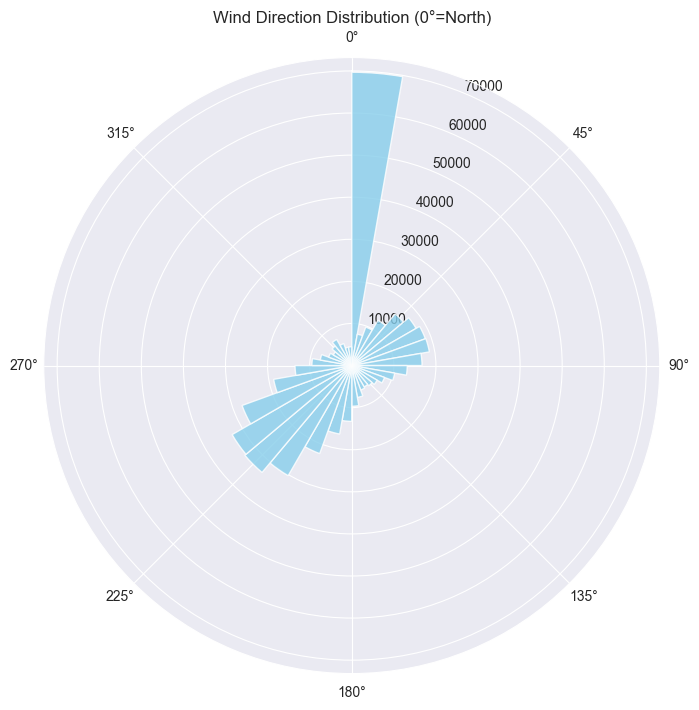

In [37]:
from matplotlib.projections import PolarAxes

# Convert degrees to radians
wd_rad = np.deg2rad(df['WD'])

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N')  # 0° = North
ax.set_theta_direction(-1)       # Clockwise
ax.hist(wd_rad, bins=36, color='skyblue', alpha=0.8)
plt.title('Wind Direction Distribution (0°=North)')
plt.show()

B. Wind Rose Diagram


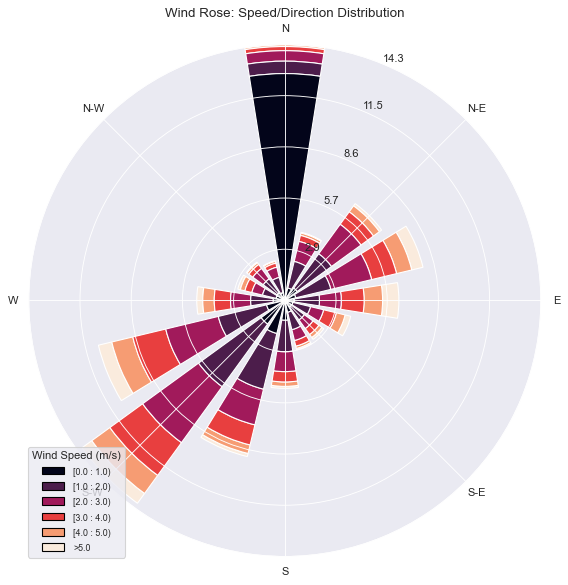

In [38]:
from windrose import WindroseAxes  # Install with: pip install windrose

ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], bins=np.arange(0, 6, 1), normed=True)
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Rose: Speed/Direction Distribution')
plt.show()

3. Wind vs. Solar Irradiance (GHI)

A. Wind Speed vs. GHI Scatter


C:\Users\getde\Desktop\solar-challenge-week1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


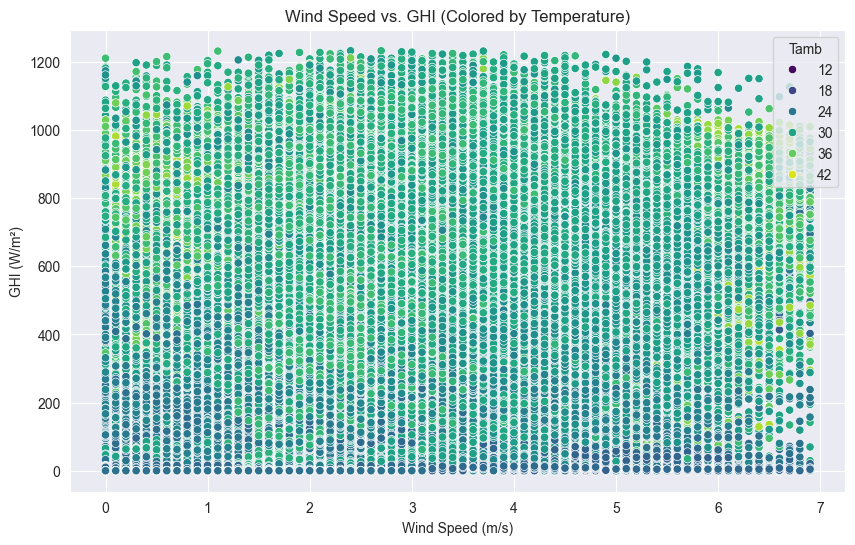

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='WS', y='GHI', hue='Tamb', palette='viridis')
plt.title('Wind Speed vs. GHI (Colored by Temperature)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.show()

B. Wind Direction Impact on GHI


C:\Users\getde\AppData\Local\Temp\ipykernel_26176\2734814295.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='WD_binned', y='GHI', palette='coolwarm')  # Bin WD into 45° segments


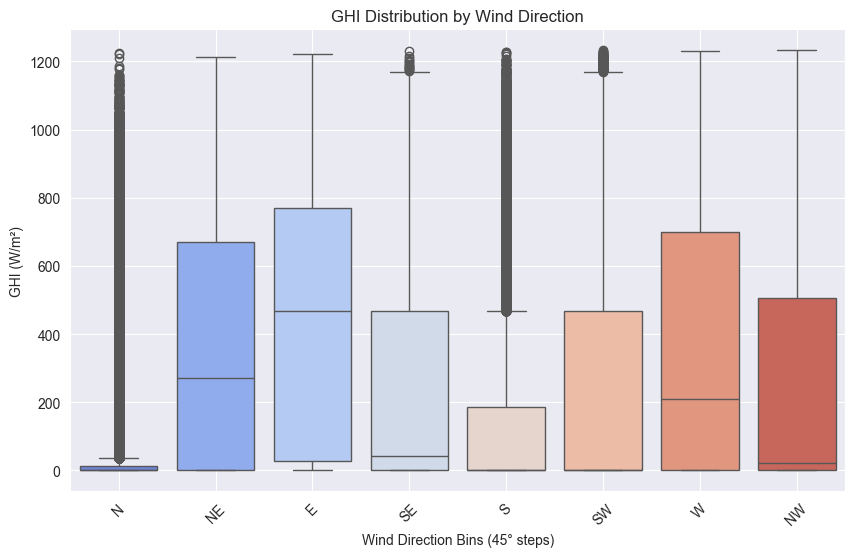

In [41]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='WD_binned', y='GHI', palette='coolwarm')  # Bin WD into 45° segments
plt.title('GHI Distribution by Wind Direction')
plt.xlabel('Wind Direction Bins (45° steps)')
plt.ylabel('GHI (W/m²)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
print(df[['WD', 'WD_binned']].drop_duplicates().sort_values('WD'))

4. Statistical Summary

Wind Metrics


In [42]:
wind_stats = df[['WS', 'WSgust', 'WD']].describe()
print(wind_stats)

                  WS         WSgust             WD
count  525600.000000  525600.000000  525600.000000
mean        2.063008       2.734595     153.435172
std         1.501714       1.893157     102.332842
min         0.000000       0.000000       0.000000
25%         1.000000       1.300000      59.000000
50%         1.900000       2.600000     181.000000
75%         3.000000       3.900000     235.100000
max         6.900000       8.700000     360.000000


Correlation with GHI


In [43]:
wind_ghi_corr = df[['WS', 'WSgust', 'WD', 'GHI']].corr()['GHI'].sort_values()
print(wind_ghi_corr)

WD        0.080629
WS        0.484594
WSgust    0.514958
GHI       1.000000
Name: GHI, dtype: float64


●	Temperature Analysis

 bubble chart to visualize the relationship between GHI (Global Horizontal Irradiance) and Tamb (Ambient Temperature), with bubble size representing RH (Relative Humidity) or BP (Barometric Pressure).

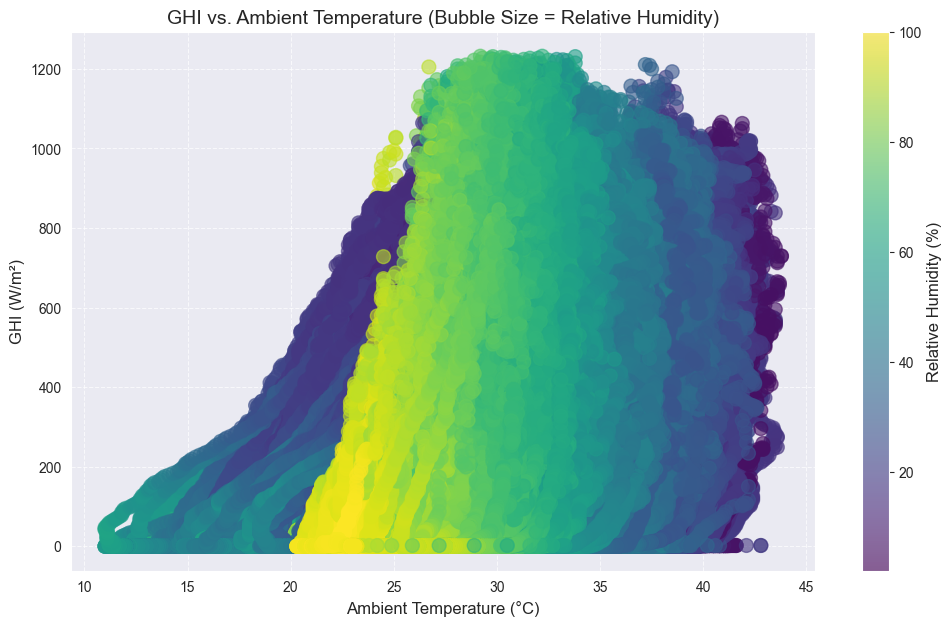

In [44]:
# Filter out negative GHI values (invalid/missing data)
df = df[df['GHI'] >= 0]

# Create figure
plt.figure(figsize=(12, 7))

# Scatter plot: GHI vs. Tamb, bubble size = RH
scatter = plt.scatter(
    x=df['Tamb'],
    y=df['GHI'],
    s=df['BP']/10,  # Scale BP for visibility
    alpha=0.6,
    c=df['RH'],     # Still color by RH for extra dimension
    cmap='viridis'
)

# Labels and title
plt.xlabel("Ambient Temperature (°C)", fontsize=12)
plt.ylabel("GHI (W/m²)", fontsize=12)
plt.title("GHI vs. Ambient Temperature (Bubble Size = Relative Humidity)", fontsize=14)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Relative Humidity (%)", fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
def regional_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Generate key statistics by region"""
    return df.groupby('Region').agg({
        'GHI': ['mean', 'std', 'max'],
        'DNI': ['median', 'max'],
        'Tamb': ['mean', 'std'],
        'WS': ['mean', 'max'],
        'Precipitation': 'sum'
    }).T.round(2)

display(regional_summary(cleaned_df))